In [2]:
import os
import pathlib
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gemmi

In [33]:
import pickle

In [13]:
import seaborn as sns

## 1. Manual parser.

#### Function.

In [69]:
def parse_pdb_Atom(file_path, start_header='ATOM', end_header='TER'):
    """ Parse PDB file to get ATOM section. """
    with open(file_path) as f:
        lines=f.readlines()
    # Parse the section between start_header and end_header. Atom section in this case.
    Atoms=[]
    for line in lines:
        # Parse ATOM section.
        Start = False
        if line.startswith(start_header):
            Start = True
        elif line.startswith(end_header):
            Start = False
        if Start:
            Atoms.append(line)
    return Atoms

In [68]:
def check_type(line, D_types=D_types):
    """ Check the type of the elements in the line if it matches the expected types in D_types. """
    elements = line.split()
    for i, (element, expected) in enumerate(zip(elements, expected_types)):
        try:
            if expected == int:
                int(element)  # Try converting to int
            elif expected == float:
                float(element)  # Try converting to float
            elif expected == str:
                pass  # Already a string
            else:
                raise ValueError("Unknown type")
        except Exception as e:
            raise AssertionError(f"Element {i} ('{element}') is not {expected.__name__}") from e


In [79]:
def parse_pdb_line(line):
    """ Parse a single line of PDB file, give a dictionary of information. """
    return {
        "header":           line[0:6].strip(),      # ATOM or HETATM
        "line_num":         int(line[6:11]),        # Atom serial number
        "at_type":          line[12:16].strip(),    # Atom name
        "res":              line[17:20].strip(),    # Residue name
        "chain":            line[21].strip(),       # Chain identifier
        "res_label_chain":  line[22:26].strip(),    # Residue sequence number
        "x":                float(line[30:38]),     # X coordinate
        "y":                float(line[38:46]),     # Y coordinate
        "z":                float(line[46:54]),     # Z coordinate
        "occupancy":        float(line[54:60]),     # Occupancy
        "bfactor":          float(line[60:66]),     # B-factor
        "at_symbol":        line[76:78].strip()     # Element symbol
    }

*check with D_types and D_keys (standard column types and names) OR use fixed-width columns but not .split() to parse line?*

In [87]:
def generate_dict(Section, D_types=D_types, D_keys=D_keys):
    """ Generate dictionary of information from the target section. """
    ## Example of coordinate lines (12 elements): "ATOM      1  N   ASN A   8     -54.578   8.517 -11.220  1.00 61.69           N  \n".
    ## Notice that for some lines, there is no empty space between any of two elements (thus 11 elements in total). 
    # ""ATOM    179  OD1AASP A  32     -64.162  22.005  33.513  0.50 26.98           O ""
    ## Thus check with D_types and D_keys (standard column types and names).
    AT_dict={}
    for i, key in enumerate(D_keys):
        AT_dict[key]=[]
        for line in Section:
            try: 
                record = parse_pdb_line(line)
            except Exception as e:
                print(f"Error parsing line: {line}")
            for k, v in record.items():
                AT_dict[k].append(v)
    return AT_dict

In [89]:
def parse_pdb_file(file_path, header1, header2=None):
    """Parse the whole PDB file."""
    records = []
    with open(file_path) as f:
        for line in f:
            if header2:
                if line.startswith((header1, header2)):
                    try:
                        record = parse_pdb_line(line)
                        records.append(record)
                    except Exception as e:
                        print(f"Error parsing line: {line}\n{e}")
            else:
                if line.startswith(header1):
                    try:
                        record = parse_pdb_line(line)
                        records.append(record)
                    except Exception as e:
                        print(f"Error parsing line: {line}\n{e}")
    return records

In [116]:
def count_res(AT_dict, label):
    """ Given the dictionary of ATOM section information, count the number of residues. """
    df_AT = pd.DataFrame(AT_dict) # Convert dictionary into dataframe.
    num_res = len(df_AT[label].unique()) # Number of resides is calculated based on unique elements of residue id.
    # Check if the residues are in the standard amino acid list.
    for A in df_AT[label].unique():
        if A not in AA:
            print(f"Warning: {A} is not in the standard amino acid list.")
    return num_res

In [98]:
def arrange_res(AT_dict):
    """ Organize the resides based on the chain and residue label. """
    df_AT = pd.DataFrame(AT_dict) # Convert dictionary into dataframe.
    chains = df_AT.chain.unique()
    chain_dict = {}
    for chain in chains:
        chain_df = df_AT[df_AT.chain == chain]
        res_labels = chain_df.res_label_chain.unique()
        num_res = len(res_labels) # Number of residues in each chain.
        chain_dict[chain] = num_res

    return chain_dict


In [88]:
file_path="/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/pdb_redo_data/2yp9_final.pdb"
AT_section=parse_pdb_Atom(file_path)
AT_dict=generate_dict(AT_section)
count_res(AT_dict)


KeyError: 'line_num'

In [109]:
file_path="/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/pdb_redo_data/2yp9_final.pdb"
AT_section=parse_pdb_file(file_path, header1='ATOM')
# count_res(AT_section)


In [110]:
AT_dict = pd.DataFrame(AT_section)
AT_dict

,header,line_num,at_type,res,chain,res_label_chain,x,y,z,occupancy,bfactor,at_symbol
0,ATOM,1,N,ASN,A,8,-54.578,8.517,-11.220,1.0,61.69,N
1,ATOM,2,CA,ASN,A,8,-53.242,8.340,-11.853,1.0,58.49,C
2,ATOM,3,CB,ASN,A,8,-53.269,7.221,-12.888,1.0,63.61,C
3,ATOM,4,CG,ASN,A,8,-53.732,7.698,-14.248,1.0,70.37,C
4,ATOM,5,OD1,ASN,A,8,-54.868,8.146,-14.415,1.0,74.24,O
...,...,...,...,...,...,...,...,...,...,...,...,...
3907,ATOM,3908,CE,LYS,A,503,-59.618,18.169,-14.683,1.0,54.72,C
3908,ATOM,3909,NZ,LYS,A,503,-59.425,17.573,-13.336,1.0,54.17,N
3909,ATOM,3910,C,LYS,A,503,-61.911,20.883,-18.789,1.0,61.07,C
3910,ATOM,3911,O,LYS,A,503,-62.131,21.380,-19.895,1.0,58.37,O


In [111]:
AA=['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']


In [112]:
AT_dict.res.unique()

array(['ASN', 'SER', 'THR', 'ALA', 'LEU', 'CYS', 'GLY', 'HIS', 'VAL',
       'PRO', 'ILE', 'LYS', 'ASP', 'GLN', 'GLU', 'PHE', 'TRP', 'ARG',
       'TYR', 'MET'], dtype=object)

In [115]:
for A in AT_dict.res.unique():
    if A in AA:
        print("True")

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [99]:
arrange_res(AT_dict)

{'A': 490}

In [100]:
# 4-chain structure.
ex_4c_AT = parse_pdb_file("/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/pdb_redo_data/1a0j_final.pdb", header1='ATOM')
ex_4c_dict = pd.DataFrame(ex_4c_AT)
arrange_res(ex_4c_dict)
# 


{'A': 220, 'B': 220, 'C': 220, 'D': 220}

In [101]:
# Total number of residues in the protein.
np.sum(list(arrange_res(ex_4c_dict).values()))

np.int64(880)

In [4]:
# Training set.
train_list = pd.read_csv("/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/train_split.txt", header=None)
train_list = train_list[0].tolist()
# Test set.
test_list = pd.read_csv("/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/test_split.txt", header=None)
test_list = test_list[0].tolist()

In [35]:
len(train_list), len(test_list)

(4507, 1293)

In [5]:
## Loop through all pdb files.
pdb_path = pathlib.Path('/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/pdb_redo_data')
pdbs = list(pdb_path.glob('*_final.pdb')) # Pay attention to the pattern of names. A general "*.pdb" would result in duplicate files when looping.
# Train.
pdb_train = []
for a in pdbs:
    name = a.stem.split('_')[0]
    if name in train_list:
        pdb_train.append(a)
# Test.
pdb_test = []
for a in pdbs:
    name = a.stem.split('_')[0]
    if name in test_list:
        pdb_test.append(a)

In [105]:
len(pdb_train)

4507

In [117]:
train_dict={}
for a in pdb_train:
    name = a.stem.split('_')[0]
    AT_dict = parse_pdb_file(a, header1='ATOM')
    AT_df = pd.DataFrame(AT_dict) # Might modify later to reduce the memory usage.
    # Summarize as {chain: num_res}.
    res_dict = arrange_res(AT_df)
    train_dict[name] = res_dict


In [124]:
# Test set.
test_dict={}
for a in pdb_test:
    name = a.stem.split('_')[0]
    AT_dict = parse_pdb_file(a, header1='ATOM')
    AT_df = pd.DataFrame(AT_dict) # Might modify later to reduce the memory usage.
    # Summarize as {chain: num_res}.
    res_dict = arrange_res(AT_df)
    test_dict[name] = res_dict


In [119]:
train_dict # Weird chain names. E.g., '3qx5'.

{'3lez': {'A': 260},
 '7sie': {'A': 255},
 '6rt3': {'A': 129},
 '3qx5': {'L': 14, 'H': 228, 'I': 10},
 '2hph': {'A': 305},
 '1od8': {'A': 302},
 '1gqv': {'A': 135},
 '2agg': {'X': 220, 'A': 2},
 '2vpa': {'A': 204},
 '6svr': {'A': 220},
 '2chh': {'A': 113},
 '6y1j': {'A': 235, 'P': 6},
 '3u3h': {'A': 386},
 '7vb1': {'A': 133},
 '8jeb': {'B': 141, 'A': 141},
 '8p8y': {'A': 232},
 '7twx': {'A': 168, 'B': 168},
 '6wcf': {'A': 166},
 '3v7x': {'A': 258},
 '5aot': {'A': 102},
 '5a8c': {'A': 299},
 '4lqh': {'A': 174},
 '8aqk': {'A': 40, 'B': 154, 'C': 2},
 '5xbx': {'A': 179},
 '7rh4': {'A': 138},
 '4nno': {'A': 278},
 '6tho': {'A': 220, 'B': 219},
 '1h13': {'A': 404},
 '3rvk': {'A': 129},
 '2vu6': {'A': 207},
 '6ttn': {'A': 300},
 '5e2f': {'A': 229, 'B': 229},
 '7rns': {'A': 110, 'B': 8},
 '5rt0': {'A': 167, 'B': 169},
 '7oyr': {'A': 257, 'B': 2},
 '5pk7': {'A': 331},
 '5mnc': {'A': 220},
 '6d1i': {'A': 229},
 '1jm1': {'A': 202},
 '3ue2': {'A': 114},
 '7wdj': {'A': 132},
 '5u69': {'A': 358},
 

In [131]:
train_dict['2yp9']

KeyError: '2yp9'

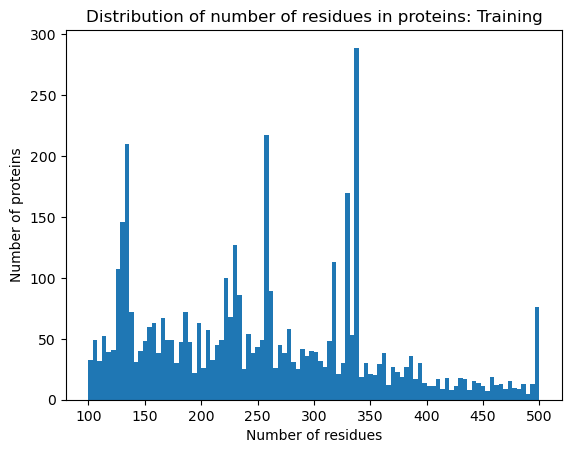

In [123]:
# Plots. Distribution of number of residues in all proteins.
raw_res_list = [np.sum(list(v.values())) for v in train_dict.values()]
len(raw_res_list)
plt.hist(raw_res_list, bins=100)
plt.xlabel("Number of residues")
plt.ylabel("Number of proteins")
plt.title("Distribution of number of residues in proteins: Training")
plt.savefig("figures/1_Parser_m_train_res_dist.png", dpi=200)
plt.show()

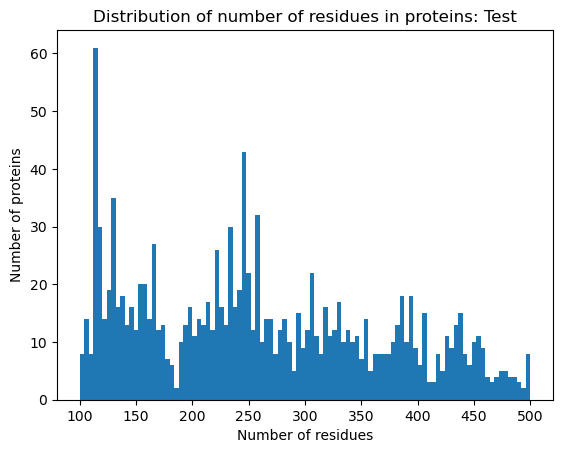

In [125]:
# Plots. Distribution of number of residues in all proteins. TEST SET.
raw_res_list = [np.sum(list(v.values())) for v in test_dict.values()]
len(raw_res_list)
plt.hist(raw_res_list, bins=100)
plt.xlabel("Number of residues")
plt.ylabel("Number of proteins")
plt.title("Distribution of number of residues in proteins: Test")
plt.savefig("figures/1_Parser_m_test_res_dist.png", dpi=200)
plt.show()

In [129]:
# Plots. Distribution of number of residues in each chain.
raw_res_list = [[].extend(list(v.values())) for v in train_dict.values()]
np.array(raw_res_list).flatten()
# len(raw_res_list)

array([None, None, None, ..., None, None, None],
      shape=(4507,), dtype=object)

In [80]:
def parse_pdb_HET(file_path, start_header='HET', start_header2='HETATM',end_header='MASTER'):
    """ Parse PDB file to get HETEROATOM information. """
    with open(file_path) as f:
        lines=f.readlines()
    # Parse the section between start_header and end_header. HETEROATOM section in this case.
    Section=[]
    for line in lines:
        # Parse HETERO section.
        Start = False
        if start_header2:
            if line.startswith((start_header, start_header2)):
                Start = True
            elif line.startswith(end_header):
                Start = False
            if Start:
                Section.append(line)
    return Section

In [10]:
HETs=[]
for line in lines:
    # Parse ATOM section.
    Start = False
    if line.startswith('HET') or line.startswith('HETATM'):
        Start = True
    elif line.startswith('TER'):
        Start = False
    if Start:
        HETs.append(line)

In [11]:
len(HETs)

699

In [12]:
HETs[:3]

['HET    EPE  A1504      15                                                       \n',
 'HET    EPE  A1505      15                                                       \n',
 'HET    EPE  A1506      15                                                       \n']

In [13]:
HETs[-1]

'HETATM 4595  O   HOH A4584     -61.022   0.604  -0.562  0.50 41.53           O  \n'

## 2. Gemmi parser.

In [71]:
structure = gemmi.read_structure("/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/pdb_redo_data/2yp9_final.pdb")

In [72]:
structure.entities # chain.

gemmi.EntityList([<gemmi.Entity 'A' polymer object at 0x17434c6f0>])

In [73]:
structure[0] # model.

<gemmi.Model 1 with 1 chain(s)>

In [74]:
# Check model.
i = 0
model = structure[i]  # consider the first model (skip if empty)
while len(model) == 0:  # sometimes the first model is empty
    i += 1
    try:
        model = structure[i]
    except Exception:
        raise ValueError("Can't read valid model from the input PDB file!")

In [75]:
model

<gemmi.Model 1 with 1 chain(s)>

In [130]:
for chain in model:
    print(chain)
    print(chain.name)
    print('residue number: ', len(chain))

<gemmi.Chain A with 1035 res>
A
residue number:  1035


In [61]:
s_4chain=gemmi.read_structure("/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/pdb_redo_data/1a0j_final.pdb")

In [62]:
for chain in s_4chain[0]:
    print(chain)
    print(chain.name)
    print('residue number: ', len(chain))

<gemmi.Chain A with 331 res>
A
residue number:  331
<gemmi.Chain B with 296 res>
B
residue number:  296
<gemmi.Chain C with 297 res>
C
residue number:  297
<gemmi.Chain D with 310 res>
D
residue number:  310


In [140]:
s_4chain[0][0][:3]

[<gemmi.Residue 16(ILE) with 8 atoms>,
 <gemmi.Residue 17(VAL) with 7 atoms>,
 <gemmi.Residue 18(GLY) with 4 atoms>]

In [142]:
[a for a in s_4chain[0][0] if a in AA]

[]

In [148]:
for a in s_4chain[0][0]:
    # print(a)
    print(a.name)
    # print(a.split('(')[1].split(')')[0])


ILE
VAL
GLY
GLY
TYR
GLU
CYS
ARG
LYS
ASN
SER
ALA
SER
TYR
GLN
ALA
SER
LEU
GLN
SER
GLY
TYR
HIS
PHE
CYS
GLY
GLY
SER
LEU
ILE
SER
SER
THR
TRP
VAL
VAL
SER
ALA
ALA
HIS
CYS
TYR
LYS
SER
ARG
ILE
GLN
VAL
ARG
LEU
GLY
GLU
HIS
ASN
ILE
ALA
VAL
ASN
GLU
GLY
THR
GLU
GLN
PHE
ILE
ASP
SER
VAL
LYS
VAL
ILE
MET
HIS
PRO
SER
TYR
ASN
SER
ARG
ASN
LEU
ASP
ASN
ASP
ILE
MET
LEU
ILE
LYS
LEU
SER
LYS
PRO
ALA
SER
LEU
ASN
SER
TYR
VAL
SER
THR
VAL
ALA
LEU
PRO
SER
SER
CYS
ALA
SER
SER
GLY
THR
ARG
CYS
LEU
VAL
SER
GLY
TRP
GLY
ASN
LEU
SER
GLY
SER
SER
SER
ASN
TYR
PRO
ASP
THR
LEU
ARG
CYS
LEU
ASP
LEU
PRO
ILE
LEU
SER
SER
SER
SER
CYS
ASN
SER
ALA
TYR
PRO
GLY
GLN
ILE
THR
SER
ASN
MET
PHE
CYS
ALA
GLY
PHE
MET
GLU
GLY
GLY
LYS
ASP
SER
CYS
GLN
GLY
ASP
SER
GLY
GLY
PRO
VAL
VAL
CYS
ASN
GLY
GLN
LEU
GLN
GLY
VAL
VAL
SER
TRP
GLY
TYR
GLY
CYS
ALA
GLN
ARG
ASN
LYS
PRO
GLY
VAL
TYR
THR
LYS
VAL
CYS
ASN
TYR
ARG
SER
TRP
ILE
SER
SER
THR
MET
SER
SER
ASN
CA
SO4
SO4
BEN
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
HOH
H

In [132]:
'1a0j' in train_list

False

With manual parser (see above), only 220 residues in each chain.

In [3]:
AA=['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 
    'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

In [151]:
structure = s_4chain
# Check model.
i = 0
model = structure[i]  # consider the first model (skip if empty)
while len(model) == 0:  # sometimes the first model is empty
    i += 1
    try:
        model = structure[i]
    except Exception:
        raise ValueError("Can't read valid model from the input PDB file!")
# Chain.
chain_dict={}
for chain in model:
    res_list=[]
    for res in chain:
        if res.name in AA:
            res_list.append(res.name)
    chain_dict[chain.name] = len(res_list)

In [152]:
chain_dict

{'A': 223, 'B': 223, 'C': 223, 'D': 223}

In [6]:
gemmi_train_dict={}
for a in pdb_train:
    name = a.stem.split('_')[0]
    structure = gemmi.read_structure(str(a))
    # Check model.
    i = 0
    model = structure[i]  # consider the first model (skip if empty)
    while len(model) == 0:  # sometimes the first model is empty
        i += 1
        try:
            model = structure[i]
        except Exception:
            raise ValueError("Can't read valid model from the input PDB file!")
    # Chain.
    chain_dict={}
    for chain in model:
        res_list=[]
        for res in chain:
            if res.name in AA: # IMPORTANT: screening if the residue is an amino acid.  
                res_list.append(res.name)
        chain_dict[chain.name] = len(res_list)
    # Summarize as {chain: num_res}.
    gemmi_train_dict[name] = chain_dict

In [7]:
gemmi_test_dict={}
for a in pdb_test:
    name = a.stem.split('_')[0]
    structure = gemmi.read_structure(str(a))
    # Check model.
    i = 0
    model = structure[i]  # consider the first model (skip if empty)
    while len(model) == 0:  # sometimes the first model is empty
        i += 1
        try:
            model = structure[i]
        except Exception:
            raise ValueError("Can't read valid model from the input PDB file!")
    # Chain.
    chain_dict={}
    for chain in model:
        res_list=[]
        for res in chain:
            if res.name in AA: # IMPORTANT: screening if the residue is an amino acid.  
                res_list.append(res.name)
        chain_dict[chain.name] = len(res_list)
    # Summarize as {chain: num_res}.
    gemmi_test_dict[name] = chain_dict

In [32]:
gemmi_train_dict # Not screening for AA before.

{'3lez': {'A': 260},
 '7sie': {'A': 255},
 '6rt3': {'A': 129},
 '3qx5': {'L': 28, 'H': 251, 'I': 10},
 '2hph': {'A': 305},
 '1od8': {'A': 302},
 '1gqv': {'A': 135},
 '2agg': {'X': 223, 'A': 2},
 '2vpa': {'A': 204},
 '6svr': {'A': 223},
 '2chh': {'A': 113},
 '6y1j': {'A': 235, 'P': 6},
 '3u3h': {'A': 386},
 '7vb1': {'A': 133},
 '8jeb': {'B': 141, 'A': 141, 'C': 0, 'D': 0, 'E': 0, 'F': 0},
 '8p8y': {'A': 232},
 '7twx': {'A': 168, 'B': 168},
 '6wcf': {'A': 166},
 '3v7x': {'A': 258},
 '5aot': {'A': 102},
 '5a8c': {'A': 299},
 '4lqh': {'A': 174},
 '8aqk': {'A': 40, 'B': 154, 'C': 2},
 '5xbx': {'A': 179, 'B': 0, 'C': 0},
 '7rh4': {'A': 138},
 '4nno': {'A': 278},
 '6tho': {'A': 220, 'B': 219},
 '1h13': {'A': 404},
 '3rvk': {'A': 129},
 '2vu6': {'A': 207},
 '6ttn': {'A': 300},
 '5e2f': {'A': 229, 'B': 229},
 '7rns': {'A': 110, 'B': 8},
 '5rt0': {'A': 167, 'B': 169},
 '7oyr': {'A': 257, 'B': 2, 'C': 0},
 '5pk7': {'A': 331},
 '5mnc': {'A': 223},
 '6d1i': {'A': 229},
 '1jm1': {'A': 202},
 '3ue2':

In [34]:
# Store the AA residue dictionaries.
with open("train_AA_dict.pkl", "wb") as f:
    pickle.dump(gemmi_train_dict, f)
with open("test_AA_dict.pkl", "wb") as f:
    pickle.dump(gemmi_test_dict, f)

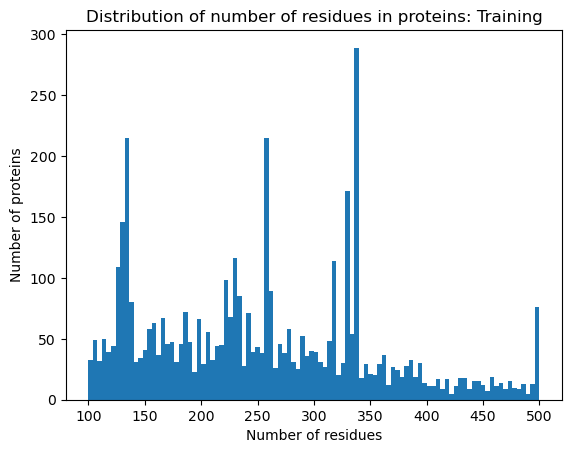

In [153]:
# Plots. Distribution of number of residues in all proteins.
raw_res_list = [np.sum(list(v.values())) for v in gemmi_train_dict.values()]
len(raw_res_list)
plt.hist(raw_res_list, bins=100)
plt.xlabel("Number of residues")
plt.ylabel("Number of proteins")
plt.title("Distribution of number of residues in proteins: Training")
plt.savefig("figures/1_Gemmi_train_res_dist.png", dpi=200)
plt.show()

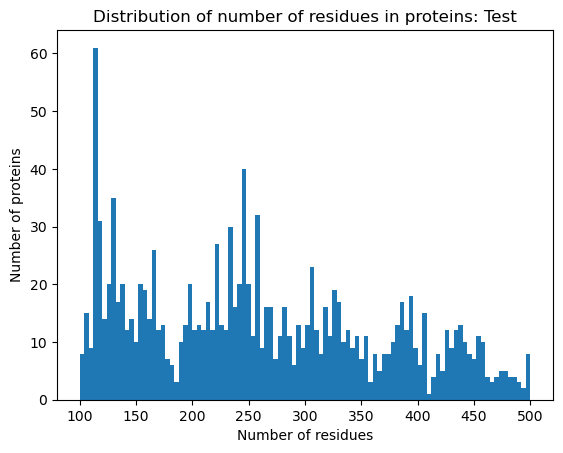

In [156]:
# Plots. Distribution of number of residues in all proteins. TEST SET.
raw_res_list = [np.sum(list(v.values())) for v in gemmi_test_dict.values()]
len(raw_res_list)
plt.hist(raw_res_list, bins=100)
plt.xlabel("Number of residues")
plt.ylabel("Number of proteins")
plt.title("Distribution of number of residues in proteins: Test")
plt.savefig("figures/1_Gemmi_test_res_dist.png", dpi=200)
plt.show()

In [158]:
nested = [list(v.values()) for v in gemmi_train_dict.values()]
flat=[item for sublist in nested for item in sublist]
len(flat)

6432

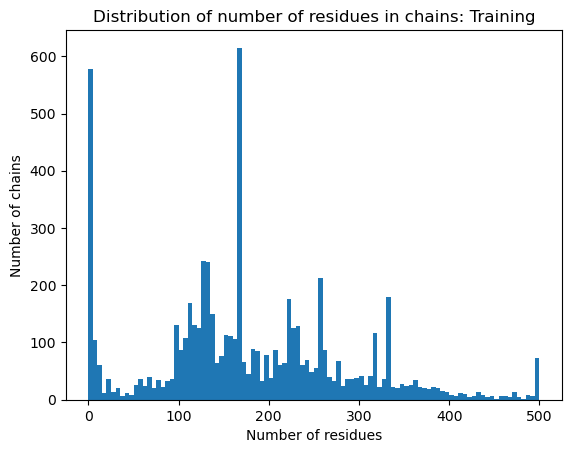

In [170]:
# Plots. Distribution of number of residues for all chains.
nested = [list(v.values()) for v in gemmi_train_dict.values()]
flat=[item for sublist in nested for item in sublist]
plt.hist(flat, bins=100)
plt.xlabel("Number of residues")
plt.ylabel("Number of chains")
plt.title("Distribution of number of residues in chains: Training")
plt.savefig("figures/1_Gemmi_train_res_chain_dist.png", dpi=200)
plt.show()

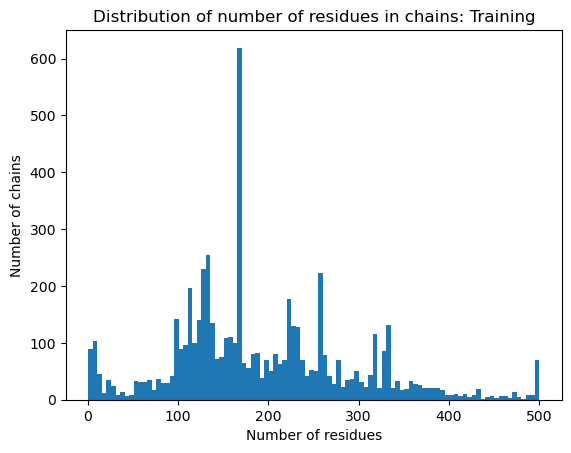

In [9]:
# Plots. Distribution of number of residues for all chains. Drop out zeros.
nested = [list(v.values()) for v in gemmi_train_dict.values()]
flat=[item for sublist in nested for item in sublist if item!= 0]
plt.hist(flat, bins=100)
plt.xlabel("Number of residues")
plt.ylabel("Number of chains")
plt.title("Distribution of number of residues in chains: Training")
plt.savefig("figures/1_Gemmi_train_res_chain_dist_drop0.png", dpi=200)
plt.show()

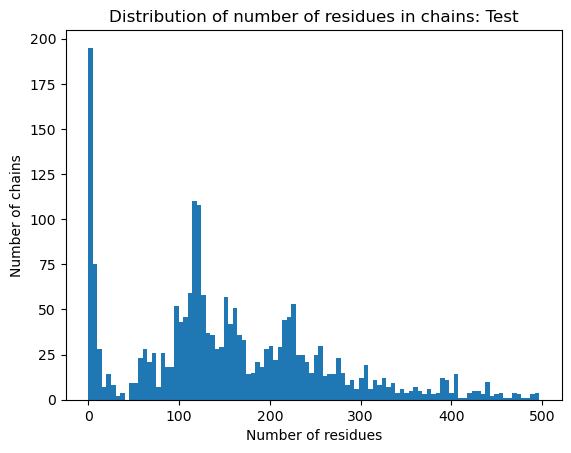

In [171]:
# Plots. Distribution of number of residues for all chains.
nested = [list(v.values()) for v in gemmi_test_dict.values()]
flat=[item for sublist in nested for item in sublist]
plt.hist(flat, bins=100)
plt.xlabel("Number of residues")
plt.ylabel("Number of chains")
plt.title("Distribution of number of residues in chains: Test")
plt.savefig("figures/1_Gemmi_test_res_chain_dist.png", dpi=200)
plt.show()

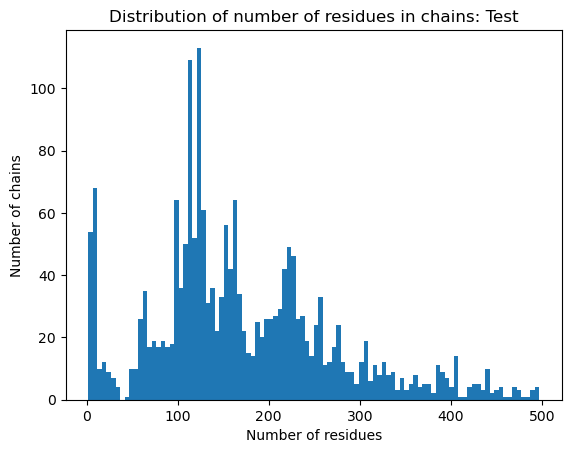

In [10]:
# Plots. Distribution of number of residues for all chains. Drop out zeros.
nested = [list(v.values()) for v in gemmi_test_dict.values()]
flat=[item for sublist in nested for item in sublist if item!= 0]
plt.hist(flat, bins=100)
plt.xlabel("Number of residues")
plt.ylabel("Number of chains")
plt.title("Distribution of number of residues in chains: Test")
plt.savefig("figures/1_Gemmi_test_res_chain_dist_drop0.png", dpi=200)
plt.show()

In [165]:
chain_list = []
for v in gemmi_train_dict.values():
    for chain, num_res in v.items():
        if num_res > 0:
            chain_list.append(len(v.keys()))

In [169]:
chain_list = [sum(1 for v in d.values() if v != 0) for k, d in gemmi_train_dict.items()]
chain_list

[1,
 1,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 12,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 3,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 3,
 1,
 4,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 4,
 1,
 1,
 1,
 1,
 4,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,

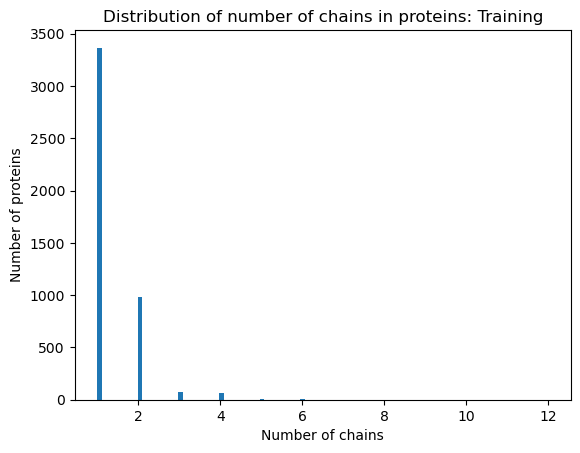

In [172]:
# Plots. Distribution of number of chains for all chains. Training set.
chain_list = [sum(1 for v in d.values() if v != 0) for k, d in gemmi_train_dict.items()]
plt.hist(chain_list, bins=100)
plt.xlabel("Number of chains")
plt.ylabel("Number of proteins")
plt.title("Distribution of number of chains in proteins: Training")
plt.savefig("figures/1_Gemmi_train_chain_dist.png", dpi=200)
plt.show()

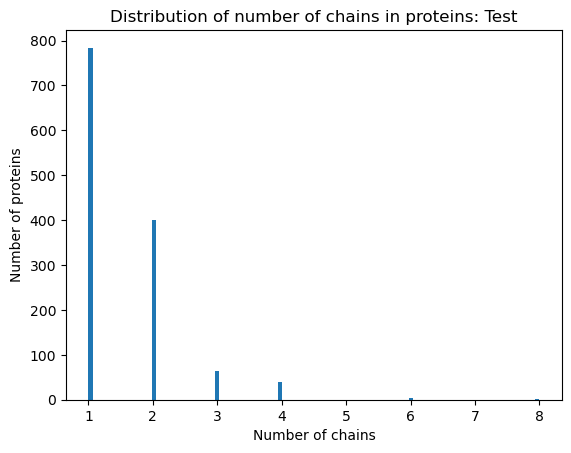

In [173]:
# Plots. Distribution of number of chains for all chains. Test set.
chain_list = [sum(1 for v in d.values() if v != 0) for k, d in gemmi_test_dict.items()]
plt.hist(chain_list, bins=100)
plt.xlabel("Number of chains")
plt.ylabel("Number of proteins")
plt.title("Distribution of number of chains in proteins: Test")
plt.savefig("figures/1_Gemmi_test_chain_dist.png", dpi=200)
plt.show()

## 2. Plotting using seaborn - PDF.

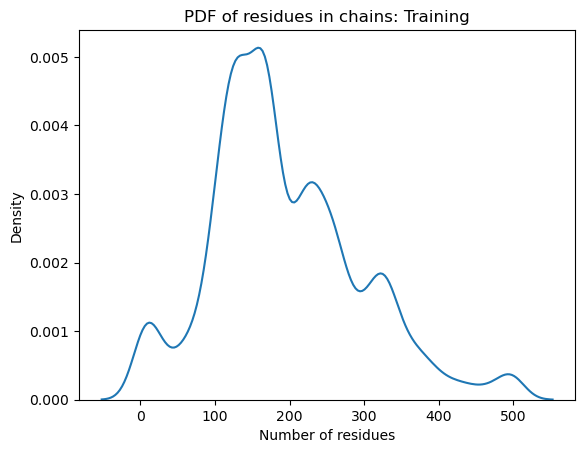

In [18]:
# Plots. Distribution of number of residues for all chains. Drop out zeros.
nested = [list(v.values()) for v in gemmi_train_dict.values()]
flat=[item for sublist in nested for item in sublist if item!= 0]
df = pd.DataFrame(flat, columns=['Number of residues'])
sns.kdeplot(df, x='Number of residues')
# sns.histplot(df, x='Number of residues')
# plt.xlabel("Number of residues")
# plt.ylabel("Number of chains")
plt.title("PDF of residues in chains: Training")
plt.savefig("figures/1_PDF_train_res_chain_dist_drop0.png", dpi=200)
plt.show()

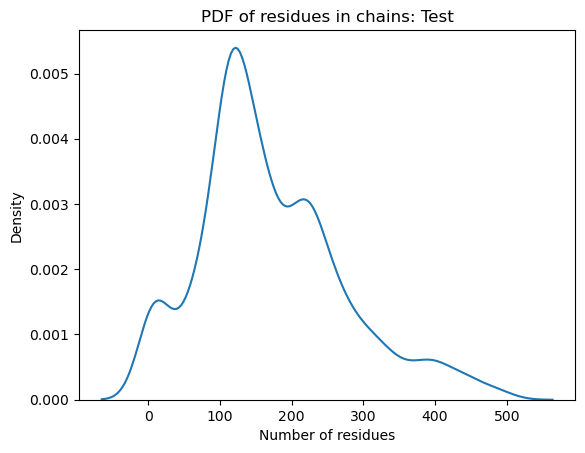

In [19]:
# Plots. Distribution of number of residues for all chains. Drop out zeros.
nested = [list(v.values()) for v in gemmi_test_dict.values()]
flat=[item for sublist in nested for item in sublist if item!= 0]
df = pd.DataFrame(flat, columns=['Number of residues'])
sns.kdeplot(df, x='Number of residues')
# sns.histplot(df, x='Number of residues')
# plt.xlabel("Number of residues")
# plt.ylabel("Number of chains")
plt.title("PDF of residues in chains: Test")
plt.savefig("figures/1_PDF_test_res_chain_dist_drop0.png", dpi=200)
plt.show()

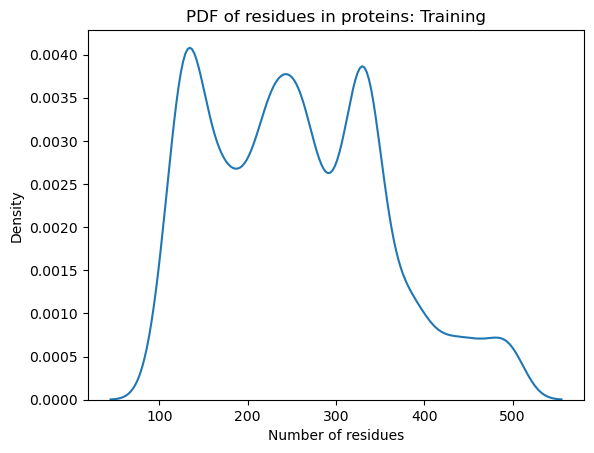

In [20]:
# Plots. Distribution of number of residues in all proteins.
raw_res_list = [np.sum(list(v.values())) for v in gemmi_train_dict.values()]
df = pd.DataFrame(raw_res_list, columns=['Number of residues'])
sns.kdeplot(df, x='Number of residues')
# plt.xlabel("Number of residues")
# plt.ylabel("Number of proteins")
plt.title("PDF of residues in proteins: Training")
plt.savefig("figures/1_PDF_train_res_dist.png", dpi=200)
plt.show()

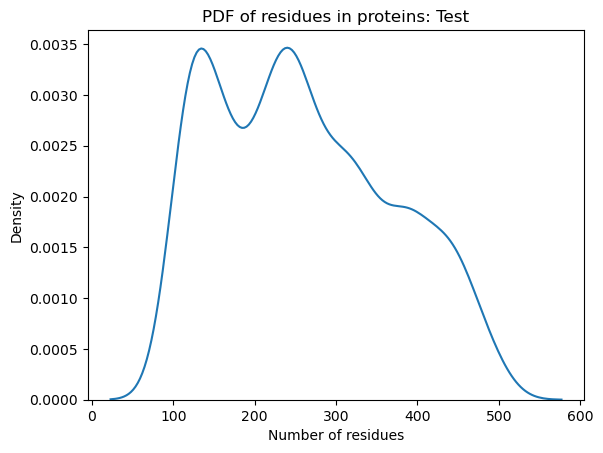

In [21]:
# Plots. Distribution of number of residues in all proteins.
raw_res_list = [np.sum(list(v.values())) for v in gemmi_test_dict.values()]
df = pd.DataFrame(raw_res_list, columns=['Number of residues'])
sns.kdeplot(df, x='Number of residues')
# plt.xlabel("Number of residues")
# plt.ylabel("Number of proteins")
plt.title("PDF of residues in proteins: Test")
plt.savefig("figures/1_PDF_test_res_dist.png", dpi=200)
plt.show()

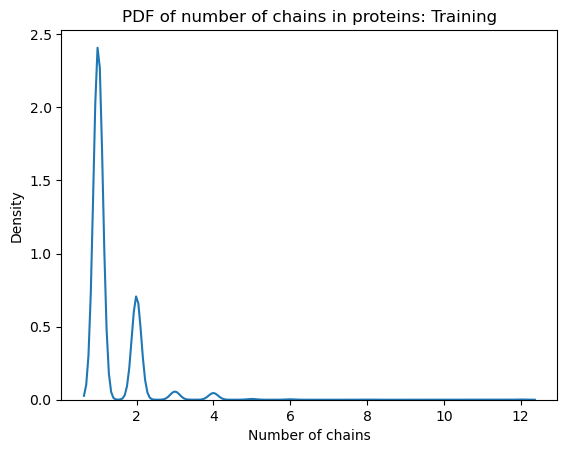

In [23]:
# Plots. Distribution of number of chains for all chains. Training set.
chain_list = [sum(1 for v in d.values() if v != 0) for k, d in gemmi_train_dict.items()]
df = pd.DataFrame(chain_list, columns=['Number of chains'])
sns.kdeplot(df, x='Number of chains')
# plt.xlabel("Number of chains")
# plt.ylabel("Number of proteins")
plt.title("PDF of number of chains in proteins: Training")
plt.savefig("figures/1_PDF_train_chain_dist.png", dpi=200)
plt.show()

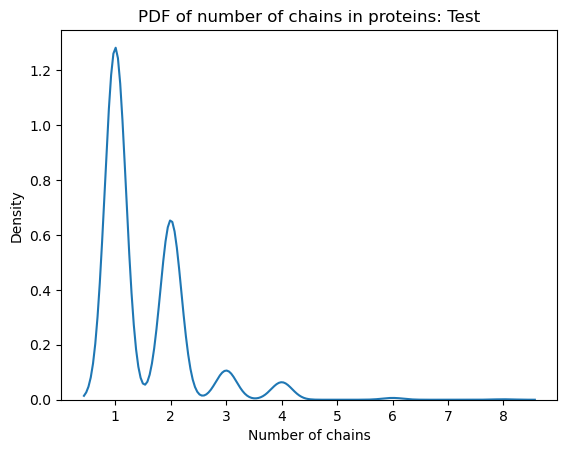

In [24]:
# Plots. Distribution of number of chains for all chains. Test set.
chain_list = [sum(1 for v in d.values() if v != 0) for k, d in gemmi_test_dict.items()]
df = pd.DataFrame(chain_list, columns=['Number of chains'])
sns.kdeplot(df, x='Number of chains')
# plt.xlabel("Number of chains")
# plt.ylabel("Number of proteins")
plt.title("PDF of number of chains in proteins: Test")
plt.savefig("figures/1_PDF_test_chain_dist.png", dpi=200)
plt.show()

#### Combined graphs.

*seaborn only takes dataframe data but not lists.*

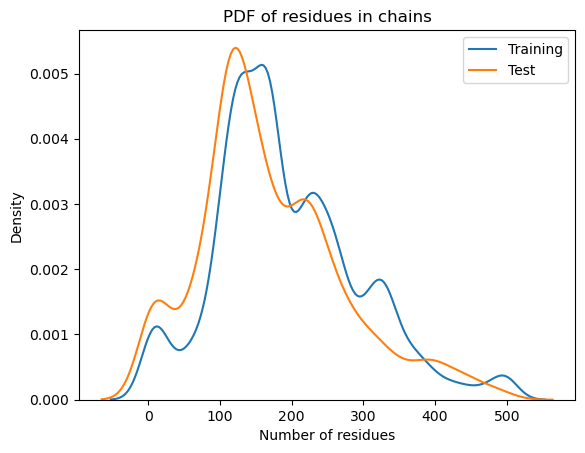

In [ ]:
# Plots. Distribution of number of residues for all chains. Drop out zeros.
nested = [list(v.values()) for v in gemmi_train_dict.values()]
flat=[item for sublist in nested for item in sublist if item!= 0]
nested2 = [list(v.values()) for v in gemmi_test_dict.values()]
flat2=[item for sublist in nested2 for item in sublist if item!= 0]
df = pd.DataFrame(flat, columns=['Number of residues'])
df2 = pd.DataFrame(flat2, columns=['Number of residues'])
sns.kdeplot(df, x='Number of residues', label='Training')
sns.kdeplot(df2, x='Number of residues', label='Test')
plt.title("PDF of residues in chains")
plt.legend()
plt.savefig("figures/1_PDF_Both_res_chain_dist_drop0.png", dpi=200)
plt.show()

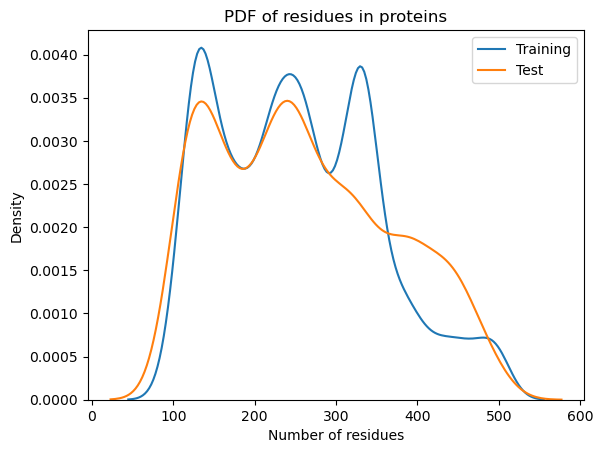

In [30]:
# Plots. Distribution of number of residues in all proteins.
raw_res_list = [np.sum(list(v.values())) for v in gemmi_train_dict.values()]
raw_res_list2 = [np.sum(list(v.values())) for v in gemmi_test_dict.values()]
df = pd.DataFrame(raw_res_list, columns=['Number of residues'])
df2 = pd.DataFrame(raw_res_list2, columns=['Number of residues'])   
sns.kdeplot(df, x='Number of residues', label='Training')
sns.kdeplot(df2, x='Number of residues', label='Test')
plt.title("PDF of residues in proteins")
plt.legend()
plt.savefig("figures/1_PDF_Both_res_dist.png", dpi=200)
plt.show()

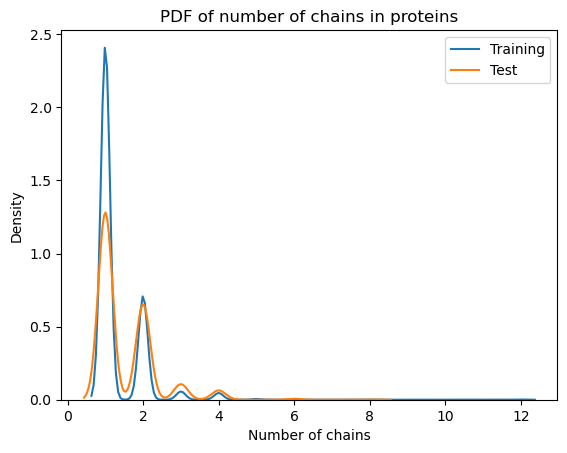

In [31]:
# Plots. Distribution of number of chains for all chains. Training set.
chain_list = [sum(1 for v in d.values() if v != 0) for k, d in gemmi_train_dict.items()]
chain_list2 = [sum(1 for v in d.values() if v != 0) for k, d in gemmi_test_dict.items()]
df = pd.DataFrame(chain_list, columns=['Number of chains'])
df2 = pd.DataFrame(chain_list2, columns=['Number of chains'])
sns.kdeplot(df, x='Number of chains', label='Training')
sns.kdeplot(df2, x='Number of chains', label='Test')
plt.legend()
plt.title("PDF of number of chains in proteins")
plt.savefig("figures/1_PDF_Both_chain_dist.png", dpi=200)
plt.show()